## Calling the Data Reader Class

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

## Drawing a Ground Truth Image

In [ ]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(train_reader, wf_path * "train/images/" * file_name, d.bboxes[file_name], 640)
img += avg_img
print("Image file is read: ", file_name, '\n')

In [ ]:
include("./BBTNet/utils/draw.jl")
draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

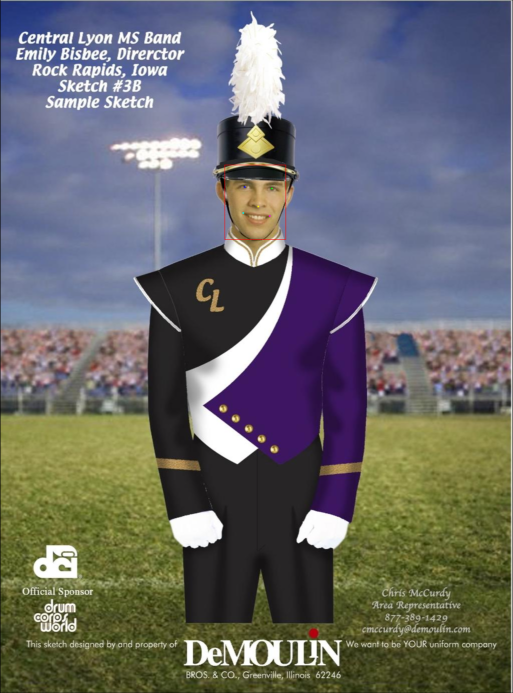

In [110]:
using Images

include("./BBTNet/utils/draw.jl")

d = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, d)

## Loading & Saving a Model

In [ ]:
model = load_model(save_dir * "PyTorch_R50_mode2_anchors3.jld2")
print("Model is loaded from a file!\n")

In [ ]:
save_model(model, save_dir * "dummy_path.jld2")

## Training the Model

In [316]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)

batch_size = 2

d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)

model = RetinaFace(dtype=atype)
train_model(model, d, save_dir=save_dir)


--- Epoch: 1 & Batch: 0/12880

ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
 

LoadError: KernelException: exception thrown during kernel execution on device Tesla T4

## Testing the Model

#### Testing a Batch

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=batch_size, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "PyTorch_R50_mode2_anchors3.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

In [ ]:
# image conversion to actual shape and cpu type for the first image in the prediction
img_no = 10
img_cpu = Array(permutedims(imgs[:,:,:,img_no], (3,2,1))) ./ 255 + avg_img
combined_pts = permutedims(Array(cat(b[img_no], l[img_no], dims=2)), (2, 1))

draw_boxes_and_landmarks(img_cpu, combined_pts)

#### Testing an Individual Image

[INFO] Returning results above confidence level: 0.2.


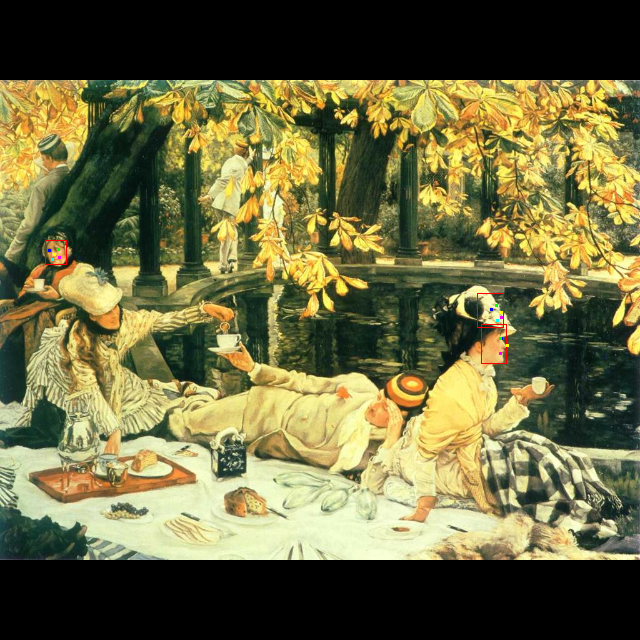

In [296]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

img_path = wf_path * "train/images/22--Picnic/22_Picnic_Picnic_22_231.jpg"

img = read_img(img_path, img_size)
imgs = convert(atype, permutedims(reshape(img, (3, img_size, img_size, 1)), (3,2,1,4)))

# model = RetinaFace(dtype=atype)
# model = load_pth_model(model, "./weights/Resnet50.jld"; dtype=atype)
model = load_model("./weights/PyTorch_R50_mode2_anchors3.jld2")
c, b, l = predict_model(model, imgs; mode=mode) 

combined_pts = cat(b[1], l[1], dims=1)
img = convert(Array{Float32}, img .+ avg_img)
img ./= 255

draw_boxes_and_landmarks(img, combined_pts)

In [301]:
size(c)

(1,)

In [311]:
include("./BBTNet/utils/box_processes.jl")

priors = _get_priorboxes()
y = cat(b[1], l[1], dims=1)
losses = rand(16800)

encode_gt_and_get_indices(y, priors, losses, 0.5, 0.4)

([0.5593958497047424 1.2360600233078012 -0.4718525111675298; -1.1908569335937536 0.16174544394016444 0.7925413846969676; … ; 2.7346391677856374 2.4633928872644906 2.978040218353275; 1.8162109851837194 1.8122969865799021 3.079732060432434], [7004, 4974, 6204], [8272, 1058, 14515, 16395, 457, 4627, 16766, 7812, 121])